In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [10]:
from google.colab import drive
drive.mount('/content/drive') # Removed the extra indent here

Mounted at /content/drive


In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio


In [11]:
import torch

if torch.cuda.is_available():
  print("GPU is available:", torch.cuda.get_device_name(0))
else:
  print("GPU is not available.")

device = torch.device('cuda')


GPU is available: NVIDIA L4


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time

In [13]:
def read_images(path, num_img):
    array = np.zeros((num_img, 64*32))
    i = 0
    for img in os.listdir(path):
        img_path = path + '/' + img
        img = Image.open(img_path, mode= 'r')
        data = np.asanyarray(img, dtype= 'uint8')
        data = data.flatten()
        array[i,:] = data
        i += 1
    return array

In [14]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/yazılım,/Yazılım/DeepLearning/IR-PEDESTRIAN/Data/LSIFIR.zip', 'r') as zip_ref:
    zip_ref.extractall('LSIFIR-DATA')

In [15]:
train_negative_path = r'/content/LSIFIR-DATA/LSIFIR/Classification/Train/neg'
num_train_negative_img = 43390

In [16]:
!ls /content/LSIFIR-DATA/

LSIFIR


Negatives

In [17]:
train_negative_array = read_images(train_negative_path, num_train_negative_img)

In [18]:
x_train_negative_tensor = torch.from_numpy(train_negative_array)

In [19]:
y_train_negative_tensor = torch.zeros(num_train_negative_img, dtype= torch.long)

Positives

In [20]:
train_positive_path = r'/content/LSIFIR-DATA/LSIFIR/Classification/Train/pos'
num_train_positive_img = 10208

In [21]:
train_positive_array = read_images(train_positive_path, num_train_positive_img)

In [22]:
x_train_positive_tensor = torch.from_numpy(train_positive_array)

In [23]:
y_train_positive_tensor = torch.ones(num_train_positive_img, dtype= torch.long)

Concat Train

In [24]:
x_train = torch.cat((x_train_negative_tensor,x_train_positive_tensor),0)
y_train = torch.cat((y_train_negative_tensor,y_train_positive_tensor),0)

In [25]:
print("x_train: ",x_train.size())
print("y_train: ",y_train.size())

x_train:  torch.Size([53598, 2048])
y_train:  torch.Size([53598])


Test Negatives

In [26]:
test_negative_path = r'/content/LSIFIR-DATA/LSIFIR/Classification/Test/neg'
num_test_negative_img = 22050

In [27]:
test_negative_array = read_images(test_negative_path,num_test_negative_img)

In [28]:
x_test_negative_tensor = torch.tensor(test_negative_array[:20855,:])
y_test_negative_tensor = torch.zeros(20855, dtype= torch.long)

Test Positives

In [29]:
test_positive_path = r'/content/LSIFIR-DATA/LSIFIR/Classification/Test/pos'
num_test_positive_img = 5944

In [30]:
test_positive_array = read_images(test_positive_path,num_test_positive_img)

In [31]:
x_test_positive_tensor = torch.tensor(test_positive_array)
y_test_positive_tensor = torch.ones(num_test_positive_img, dtype=torch.long)

Concat Test

In [32]:
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)

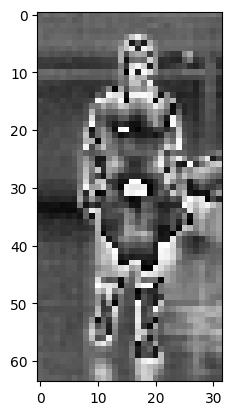

In [33]:
plt.imshow(x_train[48001,:].reshape(64,32,), cmap='gray')

HyperParameters

In [34]:
#Hyperparameter
num_epochs = 5000
num_classes = 2
batch_size = 8933
learning_rate = 0.00001

In [35]:
train = torch.utils.data.TensorDataset(x_train, y_train) # Train verilerimizi Troch için uygun formata getirme
trainloader = torch.utils.data.DataLoader(train,batch_size= batch_size, shuffle=True ) # Uygun formata getirilmiş train setimizi hyperparametreler ile initialize etme

test = torch.utils.data.TensorDataset(x_train, y_train) # Test verilerimizi Troch için uygun formata getirme
testloader = torch.utils.data.DataLoader(test,batch_size= batch_size, shuffle=False ) # Uygun formata getirilmiş train setimizi hyperparametreler ile initialize etme

<h1 style="color:blue;">ResNet

In [36]:
def conv3x3(in_planes, out_planes, stride= 1):
    return nn.Conv2d(in_planes,out_planes, kernel_size= 3, stride= stride, padding= 1, bias= False)

def conv1x1(in_planes, out_planes, stride= 1):
    return nn.Conv2d(in_planes,out_planes, kernel_size= 1, stride= stride, bias= False)

In [37]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,inplanes, planes, stride= 1, downsample= None):
        super(BasicBlock,self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace= True) # inplace = Reluyu çağırdıktan sonra sonucu kendisine eşitleme
        self.drop = nn.Dropout(0.6)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if out.shape != identity.shape:
            identity = nn.functional.adaptive_avg_pool2d(identity, out.shape[2:])

        out = out + identity  # ResNet için shortcut yaptığımız yer
        out = self.relu(out)

        return out


In [38]:
class ResNet(nn.Module):
    def __init__(self,block, layers, num_classes= num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size= 7, stride= 2, padding= 3, bias= False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace= True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1)

        self.layer1 = self._make_layer(block, 64, layers[0],stride= 1)
        self.layer2 = self._make_layer(block, 128, layers[1],stride= 2)
        self.layer3 = self._make_layer(block, 256, layers[2],stride= 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity= "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1) # tüm weight'leri 1'e eşitle
                nn.init.constant_(m.bias,0) # tüm bias'leri sıfırla

    def _make_layer(self, block, planes, blocks_num, stride= 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes*block.expansion, stride),
                nn.BatchNorm2d(planes*block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks_num):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)

        return x

In [39]:
model = ResNet(BasicBlock, [2,2,2]).to(device)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay=1e-4)

<h2> Train

In [60]:
loss_list = []
train_acc = []
test_acc = []
use_gpu = True

total_step = len(trainloader)

In [ ]:
best_acc = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.view(batch_size,1,64,32)
        images = images.float()

        if use_gpu:
            images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        #backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%2 == 0:
          print(f"epoch: {epoch} {i}/{total_step}")
    #train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
          images, labels = data
          images = images.view(batch_size,1,64,32)
          images = images.float()

          if use_gpu:
            images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print("Accuracy Train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    #test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
          images, labels = data
          images = images.view(batch_size,1,64,32)
          images = images.float()

          if use_gpu:
            images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print("Accuracy test %d %%"%(100*correct/total))
    test_acc.append(100*correct/total)

    loss_list.append(loss.item())

    if test_acc[-1] > best_acc:
      best_acc = test_acc[-1]
      torch.save(model.state_dict(), '/content/drive/MyDrive/yazılım,/Yazılım/DeepLearning/IR-PEDESTRIAN/best_resnet.pth')
      print(f"Yeni en iyi model kaydedildi! Test accuracy: {best_acc:.2f}%")


epoch: 0 0/6
epoch: 0 2/6
epoch: 0 4/6
Accuracy Train 23 %
Accuracy test 23 %
Yeni en iyi model kaydedildi! Test accuracy: 23.16%
epoch: 1 0/6
epoch: 1 2/6
epoch: 1 4/6
Accuracy Train 24 %
Accuracy test 24 %
Yeni en iyi model kaydedildi! Test accuracy: 24.21%
epoch: 2 0/6
epoch: 2 2/6
epoch: 2 4/6
Accuracy Train 25 %
Accuracy test 24 %
Yeni en iyi model kaydedildi! Test accuracy: 24.85%
epoch: 3 0/6
epoch: 3 2/6
epoch: 3 4/6
Accuracy Train 26 %
Accuracy test 25 %
Yeni en iyi model kaydedildi! Test accuracy: 25.90%
epoch: 4 0/6
epoch: 4 2/6
epoch: 4 4/6
Accuracy Train 27 %
Accuracy test 26 %
Yeni en iyi model kaydedildi! Test accuracy: 26.98%
epoch: 5 0/6
epoch: 5 2/6
epoch: 5 4/6
Accuracy Train 29 %
Accuracy test 28 %
Yeni en iyi model kaydedildi! Test accuracy: 28.65%
epoch: 6 0/6
epoch: 6 2/6
epoch: 6 4/6
Accuracy Train 30 %
Accuracy test 30 %
Yeni en iyi model kaydedildi! Test accuracy: 30.17%
epoch: 7 0/6
epoch: 7 2/6
epoch: 7 4/6
Accuracy Train 32 %
Accuracy test 32 %
Yeni en iyi 

In [58]:
  !find /content/ -name "*.pth"


/content/drive/MyDrive/yazılım,/Yazılım/DeepLearning/IR-PEDESTRIAN/model_save.pth


In [50]:
model.load_state_dict(torch.load('/content/drive/MyDrive/yazılım,/Yazılım/DeepLearning/IR-PEDESTRIAN/model_save.pth'))

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias", "conv1.bias". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([10, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).

In [49]:
/content/drive/MyDrive/yazılım,/Yazılım/DeepLearning/IR-PEDESTRIAN/model_save.pth

Data  model_save.pth  Untitled0.ipynb
